# Importing the data
- importing topics in json file
- import book df 

In [1]:
import pandas as pd 
import json
import numpy as np
pd.set_option('display.max_columns',100)


### Import good reads book from pickle

In [2]:
mybooks = pd.read_pickle('assets/my_books.pkl')

# # filer only books I have read
myreads = mybooks.query('Exclusive_Shelf == "read"')
to_read = mybooks.query("Exclusive_Shelf == 'to-read'")

# Fill missing date read with date added
myreads['Date_Read'] = myreads['Date_Read'].fillna(myreads['Date_Added'].copy())
myreads = myreads.sort_values(by='Date_Read')

/var/folders/v0/_5v45j6d3wg4y2hgk4psz0sm0000gn/T/ipykernel_58541/635520379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myreads['Date_Read'] = myreads['Date_Read'].fillna(myreads['Date_Added'].copy())


### Import topics dict from json file

In [3]:
import json

# Load JSON data from a file
with open('assets/my_topics.json') as file:
    json_data = json.load(file)

# Convert JSON data to a dictionary
my_topics = dict(json_data)

In [4]:
# creating dictionaries for read and want-to-read books
my_read_topics = {k: v for k, v in my_topics.items() if k in myreads.Title.to_list()}
my_want_titles = list(set(list(my_topics.keys())) - set(myreads.Title.to_list()))
my_want_topics = {k: v for k, v in my_topics.items() if k in my_want_titles}

# Topics visualization 

In [5]:
from apps.viz import tree_topics

In [6]:
fig = tree_topics(my_read_topics)
fig.show()

In [7]:
fig = tree_topics(my_want_topics)
fig.show()

# vizualising publication year

In [8]:
from apps.viz import viz_pub_year
fig = viz_pub_year(myreads)
fig.show()

# Vizualising timeline of books read. 

In [9]:
from apps.viz import viz_year_read
viz_year_read(myreads).show()

# Number of pages and read count

Visualising the most read page count of books

In [10]:
from apps.viz import visualize_page_categories

# Assuming you have a DataFrame 'myreads' with 'Page_Cat' column

visualize_page_categories(myreads, 'Page_Cat')



# Vizualise top categories and languages
I am using a pie chart here because I excpect few values in each variable and a large discrepancy.

In [11]:
from apps.viz import viz_top_values

In [12]:
# pie chart, top 5 categories and languages
import plotly.graph_objects as go

def viz_top_values(column, top_n=5):
    # Drop NaN values from the column
    column = column.dropna()
    value_col = column.value_counts().reset_index()

    if len(value_col) > top_n: 
        remaining_count =value_col['count'].iloc[top_n:].sum()
        other = pd.DataFrame([['Other', remaining_count]], columns=[value_col.columns[0], 'count'])
        val_df =  pd.DataFrame(pd.concat([value_col.head(top_n), other]))
    else:
        val_df = pd.DataFrame(value_col)


    labels = val_df.iloc[:, 0]
    values = val_df['count']

    # Define the color theme
    colors = ['rgb(244, 202, 228)','rgb(179, 226, 205)', 'rgb(253, 205, 172)', 'rgb(203, 213, 232)',
               'rgb(230, 245, 201)', 'rgb(255, 242, 174)',
               'rgb(241, 226, 204)', 'rgb(204, 204, 204)', 'rgb(255, 255, 204)',
               'rgb(197, 226, 255)', 'rgb(200, 200, 200)']  # Adding color for "Other"

    # Create the pie chart
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

    # Set the colors using the color theme
    fig.update_traces(marker=dict(colors=colors))

    # Set the chart title
    fig.update_layout(title=f'Top {top_n} Values of {column.name}')

    # Display the chart
    fig.show()


In [13]:
viz_top_values(mybooks['Language'], top_n=5)

In [14]:
viz_top_values(mybooks['Categories'], top_n=10)

## Rating visualised 

In [15]:
def plot_book_ratings(data):
    # Filter the data where My_Rating > 0 since this would include non rated books

    # Sort the filtered data by your own rating in descending order
    sorted_data = (
        data.query('My_Rating > 0')
        .drop_duplicates(subset=['Title', 'Author'])
        .sort_values(['My_Rating', 'Date_Read'], ascending=False)
    )
    # Select the top 10 and bottom 10 books based on your own rating
    top_books = sorted_data.head(10)
    bottom_books = sorted_data.tail(10)

    # Create the figure object with subplots
    fig = make_subplots(rows=2, cols=1, subplot_titles=("My highest Rated Books", "My lowest Rated Books"))

    # Define the Pastel1 color scheme
    pastel_colors = plotly.colors.qualitative.Pastel1

    # Add traces for top rated books
    fig.add_trace(go.Bar(
        y=top_books['Title'],
        x=top_books['My_Rating'],
        name='My Rating',
        orientation='h',
        marker=dict(color=pastel_colors[3]),
        legendgroup='My Rating'
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        y=top_books['Title'],
        x=top_books['Average_Rating_GoogleBooks'],
        name='Average Rating (Google Books)',
        orientation='h',
        marker=dict(color=pastel_colors[4]),
        legendgroup='Average Rating (Google Books)'
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        y=top_books['Title'],
        x=top_books['Average_Rating_Goodreads'],
        name='Average Rating (Goodreads)',
        orientation='h',
        marker=dict(color=pastel_colors[5]),
        legendgroup='Average Rating (Goodreads)'
    ), row=1, col=1)

    # Add traces for bottom rated books
    fig.add_trace(go.Bar(
        y=bottom_books['Title'],
        x=bottom_books['My_Rating'],
        name='My Rating',
        orientation='h',
        marker=dict(color=pastel_colors[3]),
        legendgroup='My Rating',
        showlegend=False,
    ), row=2, col=1)

    fig.add_trace(go.Bar(
        y=bottom_books['Title'],
        x=bottom_books['Average_Rating_GoogleBooks'],
        name=' ',
        orientation='h',
        marker=dict(color=pastel_colors[4]),
        legendgroup='Average Rating (Google Books)',
        showlegend=False,
    ), row=2, col=1)

    fig.add_trace(go.Bar(
        y=bottom_books['Title'],
        x=bottom_books['Average_Rating_Goodreads'],
        name='Average Rating (Goodreads)',
        orientation='h',
        marker=dict(color=pastel_colors[5]),
        legendgroup='Average Rating (Goodreads)',
        showlegend=False,
    ), row=2, col=1)

    # Update the layout
    fig.update_layout(
        title='Book Ratings<span style="font-size: 10px;"><br>Showing the latest read books</span>',
        showlegend=True,
        height=900,
        width=800,
        plot_bgcolor='rgba(255, 255, 255, 1)',
        paper_bgcolor='rgba(255, 255, 255, 1)',
        yaxis=dict(title='Title', side='top', showticklabels=True),
        xaxis=dict(title='Rating'),
        barmode='group',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.05,
            xanchor="right",
            x=1.4
            )
    )
    fig.show()

In [63]:
import plotly.express as px

def create_scatter_plot(data, title, top_rated=True):
    # Define custom colors
    my_rating_color = 'purple'
    google_books_color = 'green'
    goodreads_color = 'antiquewhite'

    # Filter the data where My_Rating > 0 since this would include non-rated books
    filtered_data = data[data['My_Rating'] > 0]

    # Sort the filtered data by your own rating in ascending order for bottom-rated books
    if top_rated:
        filtered_data = filtered_data.sort_values(['My_Rating', 'Date_Read'], ascending=False)
    else: 
        filtered_data = filtered_data.sort_values(['My_Rating', 'Date_Read'], ascending=True)

    # Select the top 10 books based on your own rating
    top_books = filtered_data.head(15)

    # Create the figure object
    fig = px.scatter()

    # Add trace for My Rating as dots
    fig.add_trace(go.Scatter(
        x=top_books['My_Rating'],
        y=top_books['Title'],
        mode='markers',
        name='My Rating',
        marker=dict(color=my_rating_color, symbol='circle', size=15),
    ))

    # Add trace for Average_Rating_GoogleBooks as dots with a different color and shape
    fig.add_trace(go.Scatter(
        x=top_books['Average_Rating_GoogleBooks'],
        y=top_books['Title'],
        mode='markers',
        name='Average Rating (Google Books)',
        marker=dict(color=google_books_color, symbol='square', size=15),
    ))

    # Add trace for Average_Rating_Goodreads as dots with a different color and shape
    fig.add_trace(go.Scatter(
        x=top_books['Average_Rating_Goodreads'],
        y=top_books['Title'],
        mode='markers',
        name='Average Rating (Goodreads)',
        marker=dict(color=goodreads_color, symbol='diamond', size=15),
    ))

    # Update the layout
    fig.update_layout(
        title= f'{title}<br><span style="font-size: 8px;">*Showing only 15 latest read books</span>',
        height=650,  # Adjust the height as needed
        width=800,
        plot_bgcolor='rgba(255, 255, 255, 1)',
        paper_bgcolor='rgba(255, 255, 255, 1)',
        yaxis=dict(title='Title', side='top', showticklabels=True),
        xaxis=dict(
            title='Rating',
            range=[0, 5.2],  # Set the X-axis range from 0 to 5
        ),
    )

    return fig

# Call the function for top-rated books
fig_top_rated = create_scatter_plot(myreads, 'Top Rated Books', top_rated=True)

# Call the function for bottom-rated books
fig_bottom_rated = create_scatter_plot(myreads, 'Bottom Rated Books', top_rated=False)

# Show both figures
fig_top_rated.show()
fig_bottom_rated.show()



In [17]:


from apps.viz import create_rating_table

# Call the function to create the rating table
rating_table = create_rating_table(myreads)

# Display the table
rating_table.show()


In [18]:
from apps.viz import create_author_table
# Call the function to create the author table
author_table = create_author_table(myreads)

# Display the table
author_table.show()

# This year in books

In [19]:
from datetime import datetime
datetime.today().year

2023

In [20]:
# Filter on books read this year using datetime to find todays year
from datetime import datetime
today_year = datetime.today().year
print(f"This year you have read {len(myreads.query('Year == @today_year'))} books. Totaling {f'{(myreads.Number_of_Pages.sum().astype(int)):,}'} pages read.")

This year you have read 51 books. Totaling 62,094 pages read.


# Word cloud from Goodreads book Description

In [21]:

import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [22]:
STOPWORDS.update({'Author', 'S', 'will','New','York','Time','book','novel', 'read', 'day', 'make','year', 'one', 'times', 'Times'})

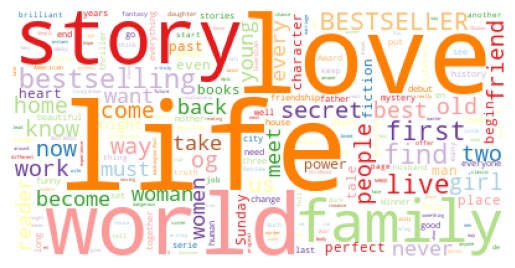

In [23]:
# Drop the rows with null values in the 'Description' column
descriptions = mybooks['Description'].dropna()
wc = WordCloud(background_color = 'white',stopwords = STOPWORDS, contour_width = 2,
     contour_color = 'white', colormap = 'Paired').generate(' '.join(descriptions))
plt.axis("off")
plt.imshow(wc)

In [24]:
myreads

,Book_Id,Title,Author,Author_l-f,Additional_Authors,ISBN_Goodreads,ISBN13,My_Rating,Average_Rating_Goodreads,Publisher,Binding,Number_of_Pages,Year_Published,Original_Publication_Year,Date_Read,Date_Added,Bookshelves,Bookshelves_with_positions,Exclusive_Shelf,My_Review,Spoiler,Private_Notes,Read_Count,Owned_Copies,Author(s),Publish_Date,Description,ISBN_GoogleBooks,Page_Count,Categories,Average_Rating_GoogleBooks,Rating_Count,Language,Page_Cat,Year,Quarter,Year_Quarter
363,774310,Animal Farm,George Orwell,"Orwell, George",NaN,"=""""","=""""",5,3.98,Penguin Books,Paperback,120.0,2000,1945,2020-06-19,2020/06/19,NaN,NaN,read,NaN,NaN,NaN,1,0,George Orwell,2011,Mr Jones of Manor Farm is so lazy and drunken ...,0143416316,94.0,NaN,4.0,1825.0,en,100-249,2020.0,2.0,2020-Q2
362,947755,Monkey Hunting: A Novel (Ballantine Reader's C...,Cristina García,"García, Cristina",NaN,"=""0345466101""","=""9780345466105""",4,3.65,Ballantine Books,Paperback,288.0,2004,2003,2020-06-19,2020/06/19,NaN,NaN,read,NaN,NaN,NaN,1,0,Cristina García,2007-12-18,"In this deeply stirring novel, acclaimed autho...",9780307416100,288.0,Fiction,2.5,2.0,en,250-349,2020.0,2.0,2020-Q2
272,2657,To Kill a Mockingbird,Harper Lee,"Lee, Harper",NaN,"=""""","=""""",4,4.26,Harper Perennial Modern Classics,Paperback,323.0,2006,1960,2020-06-19,2020/06/19,NaN,NaN,read,NaN,NaN,NaN,1,0,Harper Lee,2004,Theatre program.,9780099466734,323.0,Fiction,NaN,NaN,en,250-349,2020.0,2.0,2020-Q2
273,19063,The Book Thief,Markus Zusak,"Zusak, Markus",NaN,"=""""","=""""",4,4.39,Alfred A. Knopf,Hardcover,592.0,2006,2005,2020-06-19,2020/06/19,NaN,NaN,read,NaN,NaN,NaN,1,0,Markus Zusak,2007-09-11,"DON'T MISS BRIDGE OF CLAY, MARKUS ZUSAK'S FIRS...",PSU:000061286726,582.0,Young Adult Fiction,4.5,2494.0,en,450-599,2020.0,2.0,2020-Q2
275,929,Memoirs of a Geisha,Arthur Golden,"Golden, Arthur",NaN,"=""1400096898""","=""9781400096893""",4,4.14,Vintage Books USA,Mass Market Paperback,503.0,2005,1997,2020-06-19,2020/06/19,NaN,NaN,read,NaN,NaN,NaN,1,0,Arthur Golden,1999-01-10,"A literary sensation and runaway bestseller, t...",0679781587,452.0,Fiction,4.0,1334.0,en,450-599,2020.0,2.0,2020-Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,62334530,None of This Is True,Lisa Jewell,"Jewell, Lisa",NaN,"=""1982179007""","=""9781982179007""",5,4.26,Atria Books,Hardcover,384.0,2023,2023,2023-08-14,2023/08/14,NaN,NaN,read,NaN,NaN,NaN,1,0,Lisa Jewell,2023-08-08,From the #1 New York Times bestselling author ...,9781982179007,384.0,Fiction,NaN,NaN,en,350-449,2023.0,3.0,2023-Q3
8,8686068,"The Devotion of Suspect X (Detective Galileo, #1)",Keigo Higashino,"Higashino, Keigo","Alexander O. Smith, Elye J. Alexander","=""0312375069""","=""9780312375065""",3,4.16,Minotaur Books,Hardcover,298.0,2011,2005,2023-08-21,2023/08/21,NaN,NaN,read,NaN,NaN,NaN,1,0,Keigo Higashino,2012-01-31,Yasuko Hanaoka thought she had escaped her abu...,0349123748,448.0,Fiction,3.5,153.0,en,250-349,2023.0,3.0,2023-Q3
3,41104077,Invisible Women: Data Bias in a World Designed...,Caroline Criado Pérez,"Pérez, Caroline Criado",NaN,"=""1419729071""","=""9781419729072""",3,4.36,Abrams Press,Hardcover,318.0,2019,2019,2023-08-22,2023/08/22,NaN,NaN,read,NaN,NaN,NaN,1,0,Caroline Criado Perez,2019-03-07,*THE SUNDAY TIMES NUMBER ONE BESTSELLER* *OVER...,9781473548299,259.0,Social Science,4.0,22.0,en,250-349,2023.0,3.0,2023-Q3
11,62060421,The Girlfriend,K.L. Slater,"Slater, K.L.",NaN,"=""1803147911""","=""9781803147918""",3,4.01,Bookouture,Kindle Edition,203.0,2022,2022,2023-08-30,2023/08/30,NaN,NaN,read,NaN,NaN,NaN,1,0,K L Slater,2022-10-27,My husband's dead. She's at my door. She owns ...,180314792X,0.0,NaN,NaN,NaN,en,100-249,2023.0,3.0,2023-Q3
